#  OpenEO Use Case 2: Multi–source phenology toolbox
Use case implemented by VITO.

## Official description
This use case concentrates on data fusion tools, time-series generation and phenological
metrics using Sentinel-2 data. It will be tested on several back-end platforms by pilot users from
the Action against Hunger and the International Centre for Integrated Mountain Development.
The here tested processes depend on the availability of orthorectified Sentinel-2 surface re-
flectance data including per pixel quality masks.

## Overview

In this use case, the goal is to derive phenology information from Sentinel-2 time series data.
In this case, phenology is defined by:
- Start of season, a date and the corresponding value of the biophysical indicator
- The maximum value of the growing curve for the indicator
- End of season, a date and the corresponding value of the biophysical indicator

Multiple biophysical indicators exist. But in this use case, the enhanced vegitation index (EVI) is used.

We start by importing the necessary packages, and defining an area of interest.
During the algorithm development phase, we work on a limited study field, so that we can use
the direct execution capabilities of OpenEO to receive feedback on the implemented changes.


In [7]:

from shapely.geometry import Polygon

from openeo import ImageCollection

import openeo
import logging
import os
from pathlib import Path
import json

import numpy as np
import pandas as pd

#enable logging in requests library
from openeo.rest.imagecollectionclient import ImageCollectionClient
%matplotlib inline

start = "2017-05-01"
end = "2017-10-01"


polygon = Polygon(shell= [
            [
              5.152158737182616,
              51.18469636040683
            ],
            [
              5.15183687210083,
              51.181979395425095
            ],
            [
              5.152802467346191,
              51.18192559252128
            ],
            [
              5.153381824493408,
              51.184588760878924
            ],
            [
              5.152158737182616,
              51.18469636040683
            ]
          ])

polygon = Polygon(shell=[[5.143297433853149,51.18163191723127],[5.143297433853149,51.18450357774117],[5.159090280532837,51.18450357774117],[5.159090280532837,51.18163191723127],[5.143297433853149,51.18163191723127]])

minx,miny,maxx,maxy = polygon.bounds

#enlarge bounds, to also have some data outside of our parcel
minx -= 0.001
miny -= 0.001
maxx+=0.001
maxy+=0.001
polygon.bounds


(5.143297433853149, 51.18163191723127, 5.159090280532837, 51.18450357774117)

Connect to the OpenEO backend, and create a Sentinel-2 datacube containing 10M reflectance bands.

We do not yet specify a time range, this allows us to play around with different time ranges later on.


In [8]:
session = openeo.session("nobody", "http://openeo.vgt.vito.be/openeo/0.4.0")

#retrieve the list of available collections
collections = session.list_collections()
s2_radiometry = session.imagecollection("CGS_SENTINEL2_RADIOMETRY_V102_001") \
                    .bbox_filter(left=minx,right=maxx,top=maxy,bottom=miny,srs="EPSG:4326")


## Preprocessing step 1: EVI computation
Create an EVI data cube, based on reflectance bands. 
The formula for the EVI index can be expressed using plain Python.

The bands retrieved from the backend are unscaled reflectance values with a valid
range between 0 and 10000. 


In [9]:

B02 = s2_radiometry.band('2')
B04 = s2_radiometry.band('4')
B08 = s2_radiometry.band('8')

evi_cube_nodate: ImageCollectionClient = (2.5 * (0.0001*B08 - 0.0001*B04)) / ((0.0001*B08 + 6.0 * 0.0001*B04 - 7.5 * 0.0001*B02) + 1.0)

evi_cube = evi_cube_nodate.date_range_filter(start,end)

#write graph to json, as example
def write_graph(graph, filename):    
    with open(filename, 'w') as outfile:  
        json.dump(graph, outfile,indent=4)
write_graph(evi_cube.graph,"evi_cube.json")



### Preprocessing step 2: Cloud masking
In Sen2cor sceneclassification these values are relevant for phenology:
- 4: vegetated
- 5: not-vegetated
Everything else is cloud, snow, water, shadow ...

In OpenEO, the mask function will mask every value that is set to True.


In [10]:
s2_sceneclassification = session.imagecollection("S2_FAPAR_SCENECLASSIFICATION_V102_PYRAMID") \
                    .bbox_filter(left=minx,right=maxx,top=maxy,bottom=miny,srs="EPSG:4326")

mask = s2_sceneclassification.band('classification')

mask = mask != 4
mask


To evaluate our masking code, we download some reference images:


In [11]:
date = "2017-08-21"
mask_for_date = mask.date_range_filter(date,date)


In [12]:
mask_for_date.download("mask%s.tiff"%date,format='GTIFF')
s2_sceneclassification.date_range_filter(date,date).download("scf%s.tiff"%date,format='GTIFF')
evi_cube_nodate.date_range_filter(date,date).download("evi_unmasked%s.tiff"%date,format='GTIFF')
evi_cube_nodate.date_range_filter(date,date).mask(rastermask=mask_for_date,replacement=np.nan).download("masked%s.tiff"%date,format='GTIFF')

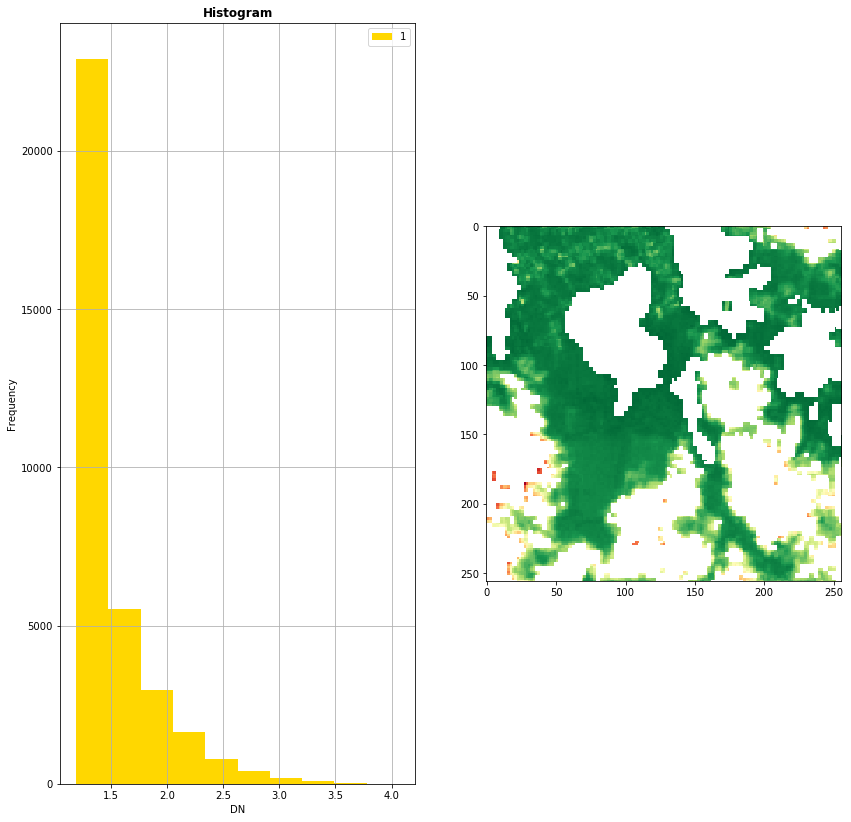

In [17]:
from rasterio.plot import show, show_hist
import rasterio
import matplotlib.pyplot as pyplot
fig, (axr, axg) = pyplot.subplots(1,2, figsize=(14,14))
with rasterio.open("evi_unmasked%s.tiff"%date) as src:
    band = src.read(1)
    show(band,ax=axg,cmap='RdYlGn_r')
    show_hist(band,ax=axr)
    

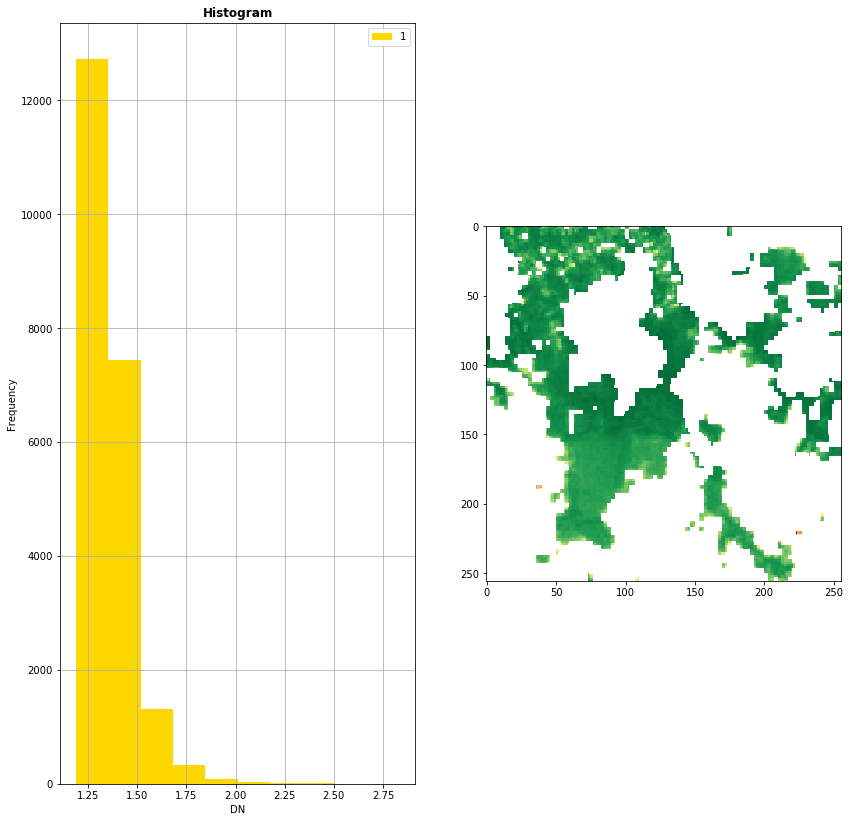

In [18]:
from rasterio.plot import show, show_hist
import rasterio
import matplotlib.pyplot as pyplot
fig, (axr, axg) = pyplot.subplots(1,2, figsize=(14,14))
with rasterio.open("masked%s.tiff"%date) as src:
    band = src.read(1)
    show(band,ax=axg,cmap='RdYlGn_r')
    show_hist(band,ax=axr)
    

We can look under the hood of OpenEO, to look at the process graph that is used to encode our workflow:

In [28]:
print(json.dumps(s2_radiometry.date_range_filter(date,date).mask(rastermask=mask_for_date,replacement=np.nan).graph,indent=1))


{
 "getcollection1": {
  "process_id": "get_collection",
  "arguments": {
   "name": "CGS_SENTINEL2_RADIOMETRY_V102_001"
  },
  "result": false
 },
 "filterbbox1": {
  "process_id": "filter_bbox",
  "arguments": {
   "data": {
    "from_node": "getcollection1"
   },
   "west": 5.143297433853149,
   "east": 5.159090280532837,
   "north": 51.18450357774117,
   "south": 51.18163191723127,
   "crs": "EPSG:4326"
  },
  "result": false
 },
 "filtertemporal1": {
  "process_id": "filter_temporal",
  "arguments": {
   "data": {
    "from_node": "filterbbox1"
   },
   "from": "2017-08-21",
   "to": "2017-08-21"
  },
  "result": false
 },
 "getcollection2": {
  "process_id": "get_collection",
  "arguments": {
   "name": "S2_FAPAR_SCENECLASSIFICATION_V102_PYRAMID"
  },
  "result": false
 },
 "filterbbox2": {
  "process_id": "filter_bbox",
  "arguments": {
   "data": {
    "from_node": "getcollection2"
   },
   "west": 5.143297433853149,
   "east": 5.159090280532837,
   "north": 51.18450357774117,


In [29]:
evi_cube_masked = evi_cube.mask(rastermask=mask.date_range_filter(start,end),replacement=np.nan)


#### Creating a viewing service

OpenEO allows us to turn a datacube into a WMTS viewing service:


In [ ]:
service = evi_cube_masked.tiled_viewing_service(type='WMTS',style={'colormap':'RdYlGn'})
print(service)


Extract an unsmoothed timeseries, this allows us to evaluate the intermediate result.
For further analysis, smoothing will be needed.


In [30]:
timeseries_raw_dc = evi_cube.polygonal_mean_timeseries(polygon)
timeseries_raw = pd.Series(timeseries_raw_dc.execute(),name="evi_raw")
timeseries_raw.head(15)


2017-05-06T00:00:00    1.359731
2017-05-13T00:00:00    1.730650
2017-05-16T00:00:00    1.409203
2017-05-23T00:00:00         NaN
2017-05-26T00:00:00    1.377697
2017-06-02T00:00:00    1.381145
2017-06-05T00:00:00    1.635941
2017-06-22T00:00:00    1.453871
2017-07-02T00:00:00         NaN
2017-07-05T00:00:00    1.733426
2017-07-07T00:00:00    1.316806
2017-07-10T00:00:00    1.234791
2017-07-12T00:00:00         NaN
2017-07-17T00:00:00    1.410478
2017-07-20T00:00:00    1.946383
Name: evi_raw, dtype: float64

In [31]:
timeseries_masked_dc = evi_cube_masked.polygonal_mean_timeseries(polygon)
timeseries_masked = pd.Series(timeseries_masked_dc.execute(),name='evi_masked')
timeseries_masked.head(15)


2017-05-06T00:00:00    1.264913
2017-05-13T00:00:00    1.589966
2017-05-16T00:00:00    1.248369
2017-05-23T00:00:00         NaN
2017-05-26T00:00:00    1.217872
2017-06-02T00:00:00    1.343648
2017-06-05T00:00:00    1.573406
2017-06-22T00:00:00         NaN
2017-07-02T00:00:00         NaN
2017-07-05T00:00:00         NaN
2017-07-07T00:00:00    1.313305
2017-07-10T00:00:00    1.193932
2017-07-12T00:00:00         NaN
2017-07-17T00:00:00    1.361956
2017-07-20T00:00:00    1.574830
Name: evi_masked, dtype: float64

Now we can plot both the cloudmasked and unmasked values. Do note that the 'unmasked' layer already has some basic cloud filtering in place based on medium and high probability clouds.

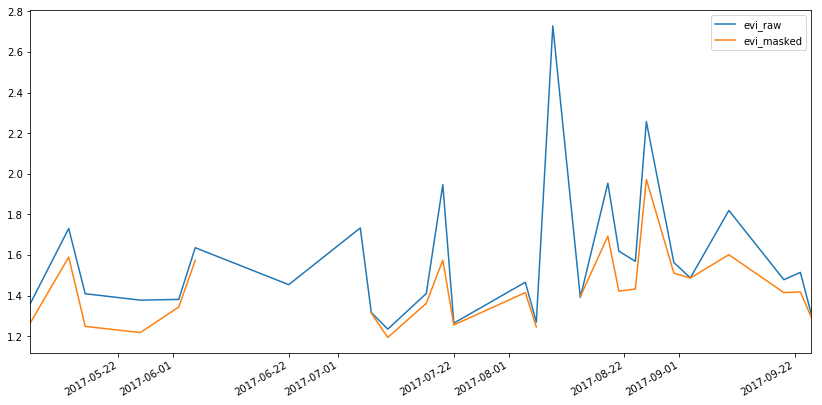

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt 

all_timeseries = pd.DataFrame([timeseries_raw.dropna(),timeseries_masked.dropna()]).T
all_timeseries.index = pd.to_datetime(all_timeseries.index)

all_timeseries.plot(figsize=(14,7))


In the plot, we can see that cloud masking seems to reduce some of the variation that is found in the original raw timeseries.

## Preprocessing step 3: Time series smoothing

Cloud masking has reduced the noise in our signal, but it is clearly not perfect. This is due to the limitations of the pixel based cloud masking algorithm, which still leaves a lot of undetected bad pixels in our data.

A commonly used approach is to apply a smoothing on the timeseries. 
Here we suggest to use a 'Savitzky-Golay' filter, which we first try out locally on the aggregated timeseries, before applying to the pixels through the OpenEO API.

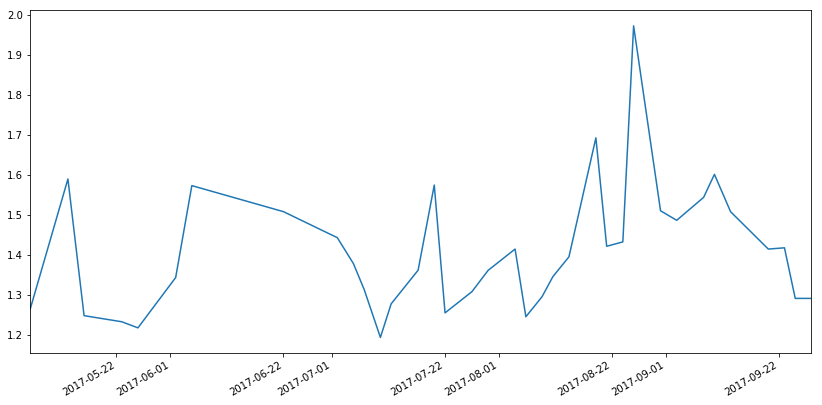

In [33]:
timeseries_masked.index = pd.to_datetime(timeseries_masked.index)
timeseries_masked.interpolate(axis=0).plot(figsize=(14,7))


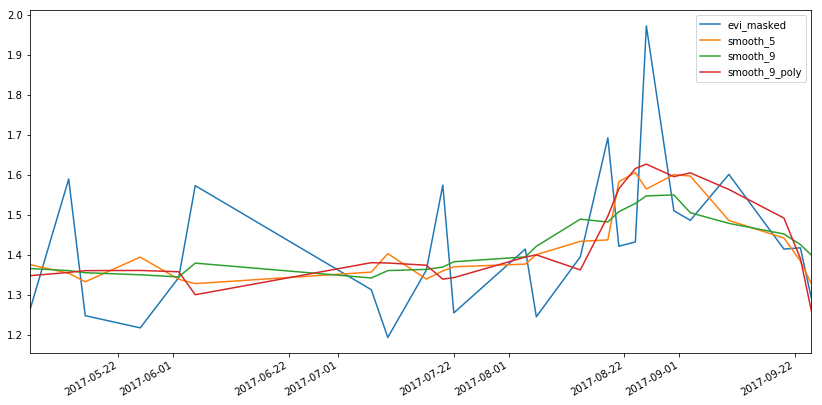

In [35]:
from scipy.signal import savgol_filter
smooth_ts = pd.DataFrame(timeseries_masked.dropna())
smooth_ts['smooth_5'] = savgol_filter(smooth_ts.evi_masked, 5, 1)
smooth_ts['smooth_9'] = savgol_filter(smooth_ts.evi_masked, 9, 1)
smooth_ts['smooth_9_poly'] = savgol_filter(smooth_ts.evi_masked, 9, 2)
smooth_ts.plot(figsize=(14,7))


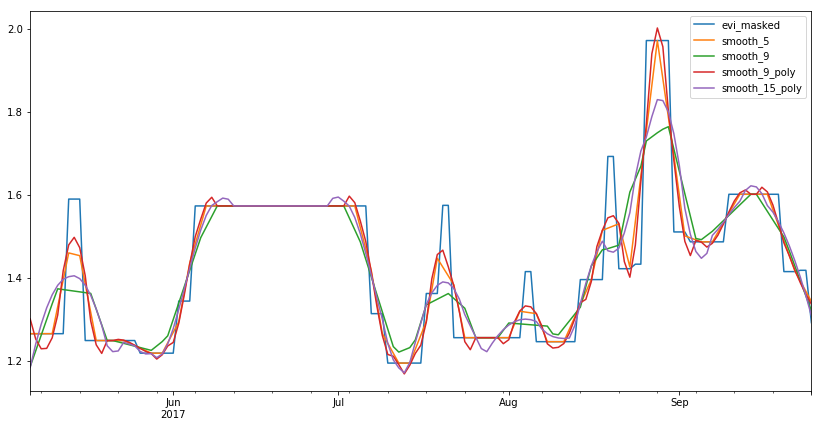

In [36]:

filled_df = pd.DataFrame(timeseries_masked.dropna().asfreq('D',method='pad'))
filled_df['smooth_5'] = savgol_filter(filled_df.evi_masked, 5, 1)
filled_df['smooth_9'] = savgol_filter(filled_df.evi_masked, 9, 1)
filled_df['smooth_9_poly'] = savgol_filter(filled_df.evi_masked, 9, 2)
filled_df['smooth_15_poly'] = savgol_filter(filled_df.evi_masked, 15, 2)

filled_df.plot(figsize=(14,7))



### Using a UDF for pixel based smoothing
The end result should be a phenology map, so we need to apply our smoothing method on the pixel values.
We use a 'user defined function' (UDF) to apply custom Python code to a datacube containging time series per pixel.

The code for our UDF function is contained in a separate file, and shown below:

In [37]:
def get_resource(relative_path):
    
    return str(Path( relative_path))
def load_udf(relative_path):
    import json
    with open(get_resource(relative_path), 'r+') as f:
        return f.read()

smoothing_udf = load_udf('udf/smooth_savitzky_golay.py')
print(smoothing_udf)

# -*- coding: utf-8 -*-
# Uncomment the import only for coding support
#from openeo_udf.api.base import SpatialExtent, RasterCollectionTile, FeatureCollectionTile, UdfData

__license__ = "Apache License, Version 2.0"


def rct_savitzky_golay(udf_data):
    from scipy.signal import savgol_filter
    import pandas as pd
    # Iterate over each tile
    for tile in udf_data.raster_collection_tiles:
        timeseries_array = tile.data
        #TODO: savitzky golay implementation assumes regularly spaced samples!

        #first we ensure that there are no nodata values in our input, as this will cause everything to become nodata.
        array_2d = timeseries_array.reshape((timeseries_array.shape[0], timeseries_array.shape[1] * timeseries_array.shape[2]))

        df = pd.DataFrame(array_2d)
        #df.fillna(method='ffill', axis=0, inplace=True)
        df.interpolate(inplace=True,axis=0)
        filled=df.as_matrix().reshape(timeseries_array.shape)

        #now apply savitzky golay on

Now we apply our udf to the temporal dimension of the datacube. Use the code block below to display the api documentation.

In [2]:
?evi_cube_masked.apply_dimension

Object `evi_cube_masked.apply_dimension` not found.


In [38]:

#S2 radiometry at VITO already has a default mask otherwise we need a masking function
smoothed_evi = evi_cube_masked.apply_dimension(smoothing_udf,runtime='Python')
timeseries_smooth = smoothed_evi.polygonal_mean_timeseries(polygon)

write_graph(timeseries_smooth.graph,"timeseries_udf.json")
ts_savgol = pd.Series(timeseries_smooth.execute())
ts_savgol.head(10)

2017-05-06T00:00:00    1.342065
2017-05-13T00:00:00    1.315788
2017-05-16T00:00:00    1.289511
2017-05-23T00:00:00    1.303183
2017-05-26T00:00:00    1.314268
2017-06-02T00:00:00    1.349746
2017-06-05T00:00:00    1.379975
2017-06-22T00:00:00    1.419937
2017-07-02T00:00:00    1.419825
2017-07-05T00:00:00    1.365087
dtype: float64

In [39]:
ts_savgol.dropna(inplace=True)
ts_savgol.index = pd.to_datetime(ts_savgol.index)
ts_savgol.head(10)

2017-05-06    1.342065
2017-05-13    1.315788
2017-05-16    1.289511
2017-05-23    1.303183
2017-05-26    1.314268
2017-06-02    1.349746
2017-06-05    1.379975
2017-06-22    1.419937
2017-07-02    1.419825
2017-07-05    1.365087
dtype: float64

,evi_raw,evi_masked,savgol_udf
2017-05-06,1.359731,1.264913,1.342065
2017-05-13,1.730650,1.589966,1.315788
2017-05-16,1.409203,1.248369,1.289511
2017-05-26,1.377697,1.217872,1.314268
2017-06-02,1.381145,1.343648,1.349746


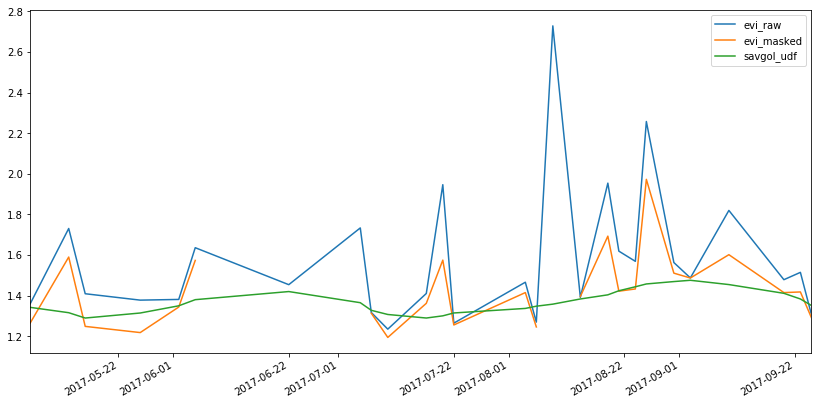

In [40]:
all_timeseries['savgol_udf'] =ts_savgol 
all_timeseries.plot(figsize=(14,7))
all_timeseries.head()



This plot shows the result of applying smoothing per pixel. The noise in the timeseries seems to be reduced, but we do still need to validate if this is correct!

### To be continued...